# Simulation of NBR07 with measured parameters. Can we detect bursts?

In [1]:
from ResSimulator import NBResonator

In [2]:
from TrappingSimulator import QPtrapper

In [3]:
savepath = r"G:\Shared drives\LFL\Projects\Quasiparticles\Simulations\expectationBursts\\"

In [4]:
import os
if not os.path.exists(savepath):
    os.makedirs(savepath)

## definition of parameters used in QP trapper

In [5]:
duration = 1 # seconds to record data
sampleRate = 30e6
N = int(duration*sampleRate)
tauTrap = 40e-6
tauRelease = 10e-6
tauCommon = 1e-4
tauRare = 1e-2
tauRecomb = 1.5e-4
phi = 0.47
Lj = 20.8475e-12 # squid inductance at zero phase bias
# Lj = 31.7299e-12
args = {'N':N,'Lj':Lj,'tauTrap':tauTrap,'tauRelease':tauRelease,'tauCommon':tauCommon,'tauRare':tauRare,
        'tauRecomb':tauRecomb,'sampleRate':sampleRate,'phi':phi,'Delta':2.72370016e-23,'T':0.010}

In [6]:
trapper = QPtrapper(**args)

## How many bursts did we get? What's the mean number of trapped QPs?

In [7]:
import numpy as np
print('We had {} burst events.'.format(len(trapper.burstIndices)))
print('The mean number of trapped QPs is {:.6}.'.format(np.mean(trapper.nTrapped)))

We had 102 burst events.
The mean number of trapped QPs is 0.575243.


## When did bursts occur?

In [8]:
time = np.arange(N)/(sampleRate*1e-6) # time in microseconds
print('Bursts occured at {}'.format(time[trapper.burstIndices]))

Bursts occured at [ 18836.1         21083.13333333  22237.03333333  24077.1
  48704.76666667  53495.06666667  64753.73333333  75014.8
  95406.26666667 105950.06666667 125838.56666667 144425.96666667
 162020.56666667 172608.43333333 176604.66666667 190014.86666667
 204094.86666667 214011.96666667 215004.26666667 215710.83333333
 227508.16666667 235800.1        245597.26666667 276049.33333333
 283586.53333333 284516.73333333 286326.1        293518.73333333
 296711.1        302707.         309302.6        314034.4
 320362.76666667 331110.2        333966.46666667 334733.76666667
 336001.53333333 343894.26666667 378018.1        382474.23333333
 401710.1        404790.63333333 412833.03333333 436755.53333333
 438701.93333333 439328.73333333 442703.9        444023.2
 469748.73333333 471343.03333333 476397.1        500690.7
 509211.73333333 510953.6        518646.56666667 519793.46666667
 530540.76666667 532368.7        549373.83333333 551353.8
 564242.53333333 567971.13333333 588633.86666667 

## Let's look at the QP occupation at a few times, including around one of these bursts

In [9]:
import matplotlib.pyplot as plt

In [10]:
plt.rcParams.update({'font.size':20})

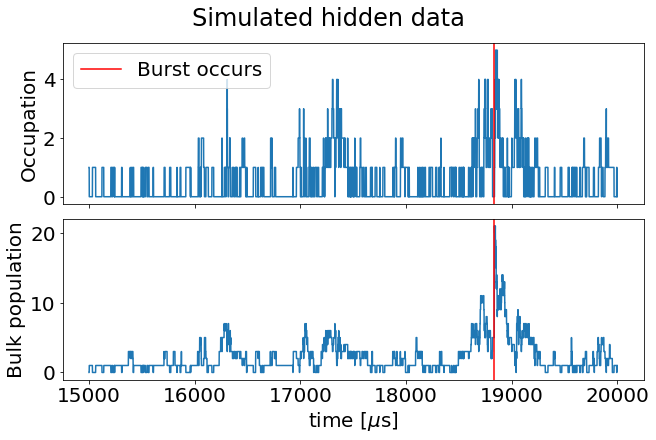

In [15]:
mask = np.logical_and(time > 15000,time < 20000)
fig,ax = plt.subplots(2,1,sharex=True,figsize=[9,6],constrained_layout=True)
ax[0].plot(time[mask],np.asarray(trapper.nTrapped)[mask])
ax[0].set_ylabel('Occupation')
ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
ax[0].legend();
ax[1].plot(time[mask],np.asarray(trapper.bulkPop)[mask])
ax[1].axvline(time[trapper.burstIndices[0]],color='red')
ax[1].set_xlabel('time [$\mu$s]')
ax[1].set_ylabel('Bulk population')
fig.suptitle('Simulated hidden data');
plt.show();
plt.close();

In [12]:
trapper.burstIndices[0]

565083

## Now we have the trapping events, let's generate the resonator response. define some more parameters

In [22]:
L = 1.82897e-9
C = 0.739929e-12
# L = 2.7837e-9
# C = 0.486155e-12
Qi = 53000
Qe = 25000
photonRO = 45
photonNoise = 2
delKappa = -0.5

resArgs = {'L':L,'C':C,'photonRO':photonRO,'photonNoise':photonNoise,'Qi':Qi,'Qe':Qe,'sampleRate':sampleRate,'delKappa':delKappa}

res = NBResonator(trapper,**resArgs)

In [23]:
res.dParams

{'fd': 4272530257.463969,
 'f0': 4272656018.6599903,
 'Qt': 16987.17948717949,
 'Qi': 53000,
 'Qe': 25000,
 'N': 30000000,
 'q': 0.024668550989454804,
 'photonRO': 45,
 'sampleRate': 30000000.0,
 'kappa': 1580361.7981041481,
 'fwhm': 251522.39204187112,
 'diameter': 1.358974358974359,
 'freq_shift': 226716.16930863354,
 'SNR': 0.3488723214682741,
 'SNRdB': -4.573334848666626,
 'sigma': 1.6930381424321308}

In [24]:
np.shape(res.signal)

(30000000,)

In [25]:
from fitTools.quasiparticleFunctions import *

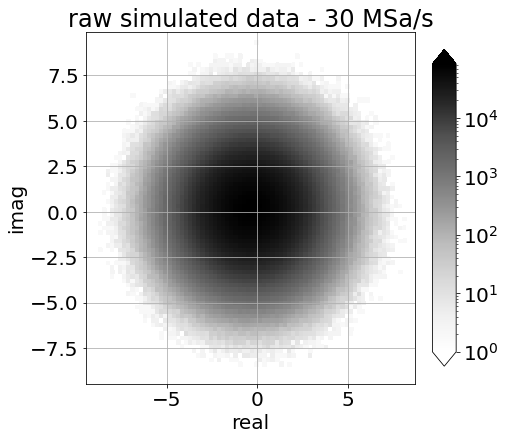

In [27]:
h = plotComplexHist(res.signal.real,res.signal.imag)
h.set_xlabel('real')
h.set_ylabel('imag')
plt.title('raw simulated data - 30 MSa/s')
plt.show();
plt.close();

## start some analysis with integration for desired SNR

In [28]:
from scipy.constants import pi
from scipy.signal import windows, convolve
avgTime5 = 4*res.dParams['Qt']*5/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
avgTime10 = 4*res.dParams['Qt']*10/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
avgTime25 = 4*res.dParams['Qt']*25/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
avgTime50 = 4*res.dParams['Qt']*50/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
print('integrate for {} us for RF power SNR=5'.format(avgTime5*1e6))
print('integrate for {} us for RF power SNR=50'.format(avgTime50*1e6))

integrate for 0.2812295545093624 us for RF power SNR=5
integrate for 2.8122955450936233 us for RF power SNR=50


### perform downsample to 3 us

In [83]:
nAvg = int(max(3e-6*res.dParams['sampleRate'],1))
# window = windows.hann(nAvg)
# rhann = convolve(res.signal.real,window,mode='same')/sum(window)
# ihann = convolve(res.signal.imag,window,mode='same')/sum(window)
rds = np.mean(res.signal.real[:len(res.signal)//(nAvg)*nAvg].reshape((len(res.signal)//(nAvg),nAvg)),axis=1)
ids = np.mean(res.signal.imag[:len(res.signal)//(nAvg)*nAvg].reshape((len(res.signal)//(nAvg),nAvg)),axis=1)

In [84]:
print(nAvg)
print('new sample rate = {:.4} MS/s'.format(sampleRate*1e-6/nAvg))
SR2 = res.dParams['sampleRate']*1e-6/nAvg

90
new sample rate = 0.3333 MS/s


### Plot a segment as time series for visual

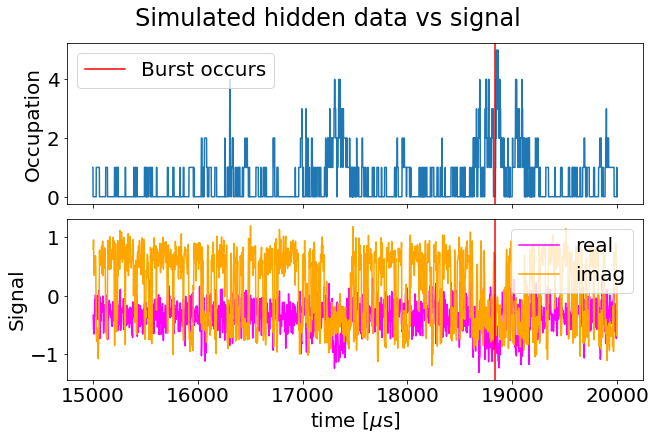

In [85]:
time2 = np.arange(len(rds))/SR2 # time in microseconds
mask = np.logical_and(time > 15000,time < 20000)
mask2 = np.logical_and(time2 > 15000, time2 < 20000)
fig,ax = plt.subplots(2,1,sharex=True,figsize=[9,6],constrained_layout=True)
ax[0].plot(time[mask],np.asarray(trapper.nTrapped)[mask])
ax[0].set_ylabel('Occupation')
ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
ax[0].legend();
ax[1].plot(time2[mask2],rds[mask2],color='magenta',label='real')
ax[1].plot(time2[mask2],ids[mask2],color='orange',label='imag')
ax[1].axvline(time[trapper.burstIndices[0]],color='red')
ax[1].set_xlabel('time [$\mu$s]')
ax[1].set_ylabel('Signal')
ax[1].legend();
fig.suptitle('Simulated hidden data vs signal');
plt.show();
plt.close();

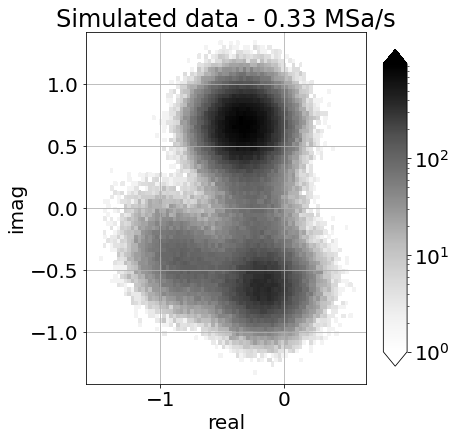

In [86]:
h = plotComplexHist(rds,ids)
h.set_xlabel('real')
h.set_ylabel('imag')
plt.title('Simulated data - {:.2} MSa/s'.format(SR2))
plt.show();
plt.close();

## Compare with Hann Convolution

In [94]:
(rhann,ihann) = np.vsplit(HannConvolution(np.vstack((res.signal.real,res.signal.imag)),5e-6,res.dParams['sampleRate']),2)

In [96]:
rhann.shape

(1, 30000000)

In [97]:
rhann = np.squeeze(rhann)
ihann = np.squeeze(ihann)

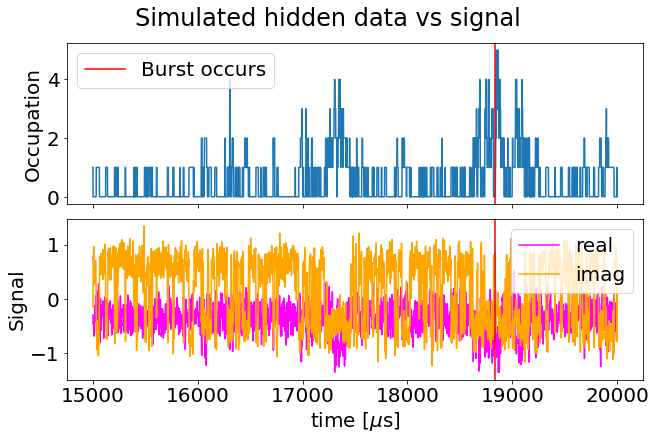

In [98]:
# time2 = np.arange(len(rds))/SR2 # time in microseconds
mask = np.logical_and(time > 15000,time < 20000)
# mask2 = np.logical_and(time2 > 15000, time2 < 20000)
fig,ax = plt.subplots(2,1,sharex=True,figsize=[9,6],constrained_layout=True)
ax[0].plot(time[mask],np.asarray(trapper.nTrapped)[mask])
ax[0].set_ylabel('Occupation')
ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
ax[0].legend();
ax[1].plot(time[mask],rhann[mask],color='magenta',label='real')
ax[1].plot(time[mask],ihann[mask],color='orange',label='imag')
ax[1].axvline(time[trapper.burstIndices[0]],color='red')
ax[1].set_xlabel('time [$\mu$s]')
ax[1].set_ylabel('Signal')
ax[1].legend();
fig.suptitle('Simulated hidden data vs signal');
plt.show();
plt.close();

## compare with savitzky golay filter

In [41]:
from scipy.signal import savgol_filter

In [73]:
window = int(max(5e-6*res.dParams['sampleRate'],1))
window += 0 if window%2 else 1
print(window)

151


### savgol with 5th order polynomial

In [74]:
rsg = savgol_filter(res.signal.real,window,5)
isg = savgol_filter(res.signal.imag,window,5)

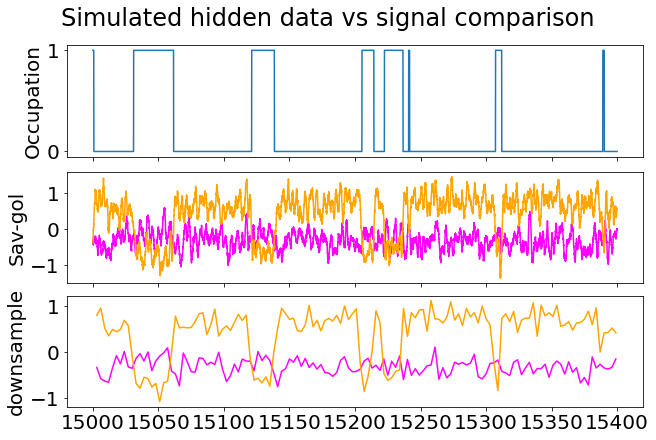

In [75]:
# time2 = np.arange(len(rhann))/SR2 # time in microseconds
mask = np.logical_and(time > 15000,time < 15400)
mask2 = np.logical_and(time2 > 15000, time2 < 15400)
fig,ax = plt.subplots(3,1,sharex=True,figsize=[9,6],constrained_layout=True)
ax[0].plot(time[mask],np.asarray(trapper.nTrapped)[mask])
ax[0].set_ylabel('Occupation')
# ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
# ax[0].legend();
ax[1].plot(time[mask],rsg[mask],color='magenta',label='real')
ax[1].plot(time[mask],isg[mask],color='orange',label='imag')
# ax[1].axvline(time[trapper.burstIndices[0]],color='red')
# ax[1].set_xlabel('time [$\mu$s]')
ax[1].set_ylabel('Sav-gol')
# ax[1].legend();
ax[2].plot(time2[mask2],rds[mask2],color='magenta')
ax[2].plot(time2[mask2],ids[mask2],color='orange')
ax[2].set_ylabel('downsample')
fig.suptitle('Simulated hidden data vs signal comparison');
plt.show();
plt.close();

### savgol with 3rd order polynomial

In [76]:
rsg = savgol_filter(res.signal.real,window,3)
isg = savgol_filter(res.signal.imag,window,3)

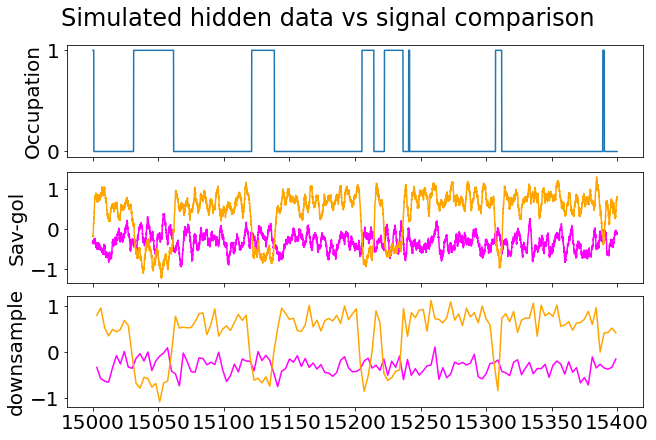

In [77]:
# time2 = np.arange(len(rhann))/SR2 # time in microseconds
mask = np.logical_and(time > 15000,time < 15400)
mask2 = np.logical_and(time2 > 15000, time2 < 15400)
fig,ax = plt.subplots(3,1,sharex=True,figsize=[9,6],constrained_layout=True)
ax[0].plot(time[mask],np.asarray(trapper.nTrapped)[mask])
ax[0].set_ylabel('Occupation')
# ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
# ax[0].legend();
ax[1].plot(time[mask],rsg[mask],color='magenta',label='real')
ax[1].plot(time[mask],isg[mask],color='orange',label='imag')
# ax[1].axvline(time[trapper.burstIndices[0]],color='red')
# ax[1].set_xlabel('time [$\mu$s]')
ax[1].set_ylabel('Sav-gol')
# ax[1].legend();
ax[2].plot(time2[mask2],rds[mask2],color='magenta')
ax[2].plot(time2[mask2],ids[mask2],color='orange')
ax[2].set_ylabel('downsample')
fig.suptitle('Simulated hidden data vs signal comparison');
plt.show();
plt.close();

### savgol with 9th order polynomial

In [78]:
rsg = savgol_filter(res.signal.real,window,9)
isg = savgol_filter(res.signal.imag,window,9)

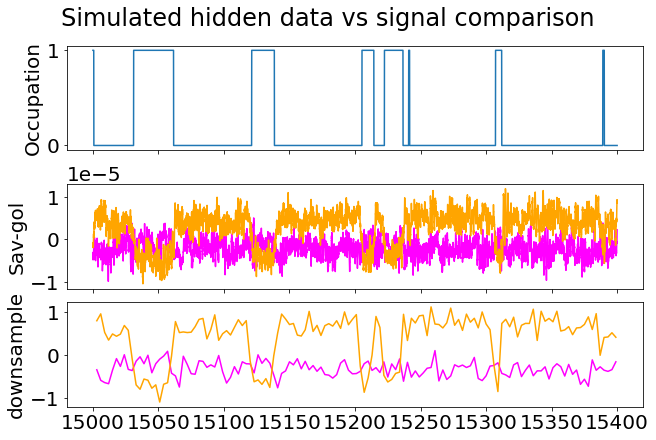

In [79]:
# time2 = np.arange(len(rhann))/SR2 # time in microseconds
mask = np.logical_and(time > 15000,time < 15400)
mask2 = np.logical_and(time2 > 15000, time2 < 15400)
fig,ax = plt.subplots(3,1,sharex=True,figsize=[9,6],constrained_layout=True)
ax[0].plot(time[mask],np.asarray(trapper.nTrapped)[mask])
ax[0].set_ylabel('Occupation')
# ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
# ax[0].legend();
ax[1].plot(time[mask],rsg[mask],color='magenta',label='real')
ax[1].plot(time[mask],isg[mask],color='orange',label='imag')
# ax[1].axvline(time[trapper.burstIndices[0]],color='red')
# ax[1].set_xlabel('time [$\mu$s]')
ax[1].set_ylabel('Sav-gol')
# ax[1].legend();
ax[2].plot(time2[mask2],rds[mask2],color='magenta')
ax[2].plot(time2[mask2],ids[mask2],color='orange')
ax[2].set_ylabel('downsample')
fig.suptitle('Simulated hidden data vs signal comparison');
plt.show();
plt.close();

## 5th order looks best, so we'll stick with that

In [80]:
rsg = savgol_filter(res.signal.real,window,5)
isg = savgol_filter(res.signal.imag,window,5)

### Look at all 3 options next to each other

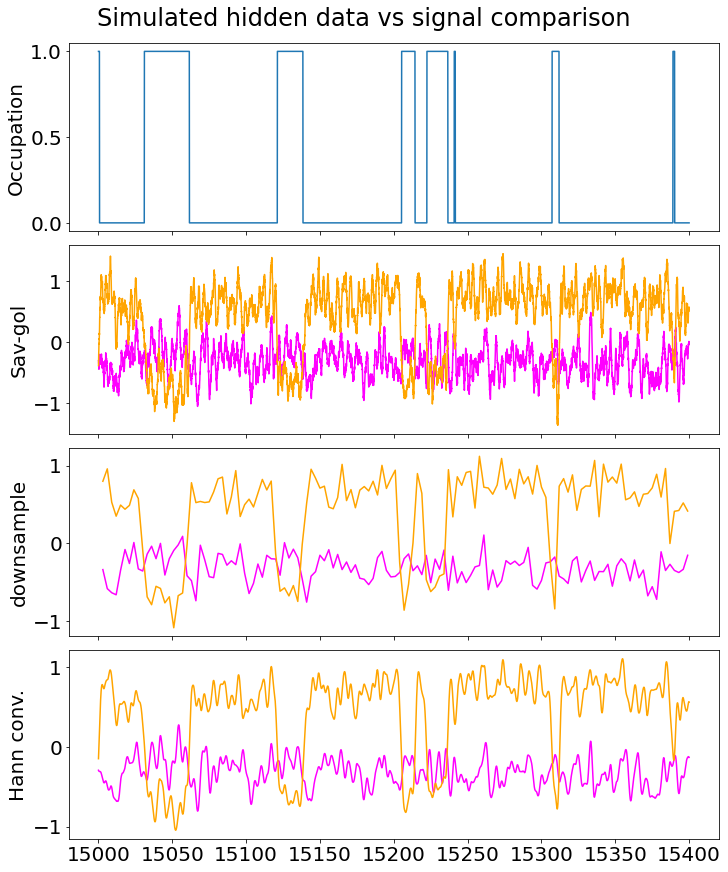

In [99]:
# time2 = np.arange(len(rhann))/SR2 # time in microseconds
mask = np.logical_and(time > 15000,time < 15400)
mask2 = np.logical_and(time2 > 15000, time2 < 15400)
fig,ax = plt.subplots(4,1,sharex=True,figsize=[10,12],constrained_layout=True)
ax[0].plot(time[mask],np.asarray(trapper.nTrapped)[mask])
ax[0].set_ylabel('Occupation')
# ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
# ax[0].legend();
ax[1].plot(time[mask],rsg[mask],color='magenta',label='real')
ax[1].plot(time[mask],isg[mask],color='orange',label='imag')
# ax[1].axvline(time[trapper.burstIndices[0]],color='red')
# ax[1].set_xlabel('time [$\mu$s]')
ax[1].set_ylabel('Sav-gol')
# ax[1].legend();
ax[2].plot(time2[mask2],rds[mask2],color='magenta')
ax[2].plot(time2[mask2],ids[mask2],color='orange')
ax[2].set_ylabel('downsample')
ax[3].plot(time[mask],rhann[mask],color='magenta')
ax[3].plot(time[mask],ihann[mask],color='orange')
ax[3].set_ylabel('Hann conv.')
fig.suptitle('Simulated hidden data vs signal comparison');
plt.show();
plt.close();

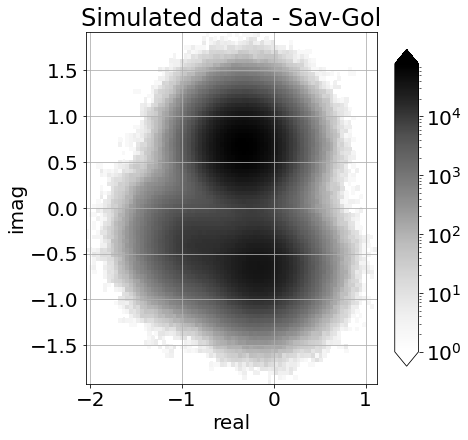

In [100]:
h = plotComplexHist(rsg,isg)
h.set_xlabel('real')
h.set_ylabel('imag')
plt.title('Simulated data - Sav-Gol')
plt.show();
plt.close();

## Let's compare Gaussian mixture extraction results

In [82]:
from sklearn.mixture import GaussianMixture

In [110]:
means_guess = [[-0.31548964,  0.64468878],
       [-0.17672003, -0.55366221],
       [-0.82593644, -0.39976375]]
gmmDS = GaussianMixture(n_components=3,means_init=means_guess)
gmmSG = GaussianMixture(n_components=3,means_init=means_guess)
gmmHC = GaussianMixture(n_components=3,means_init=means_guess)

In [111]:
gmmDS.fit(np.vstack((rds,ids)).T)
gmmSG.fit(np.vstack((rsg,isg)).T)
gmmHC.fit(np.vstack((rhann,ihann)).T)

GaussianMixture(means_init=array([[-0.31548964,  0.64468878],
       [-0.17672003, -0.55366221],
       [-0.82593644, -0.39976375]]),
                n_components=3)

[0.59899988 0.2962264  0.10477372]


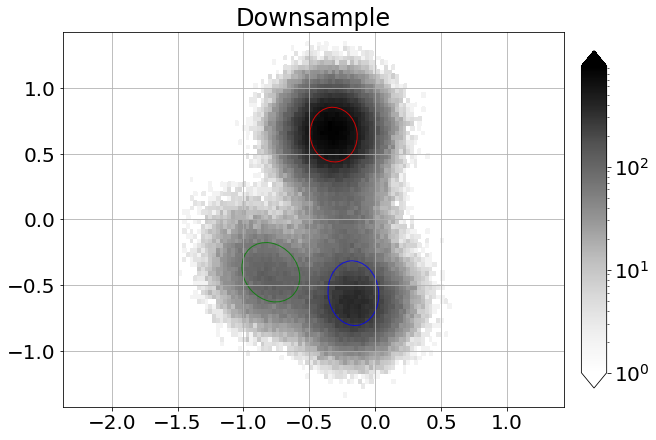

In [112]:
h = plotComplexHist(rds,ids)
make_ellipses(gmmDS,h,['red','blue','green'])
plt.title('Downsample')
print(gmmDS.weights_)

[0.60143513 0.2725266  0.12603827]


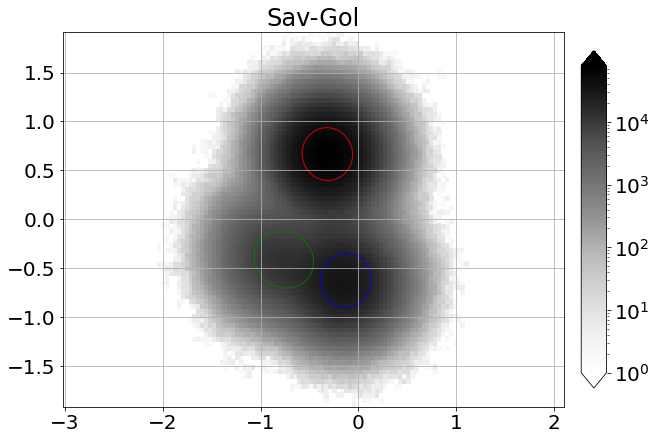

In [117]:
h = plotComplexHist(rsg,isg)
make_ellipses(gmmSG,h,['red','blue','green'])
plt.title('Sav-Gol')
print(gmmSG.weights_)

[0.59968708 0.2914816  0.10883132]


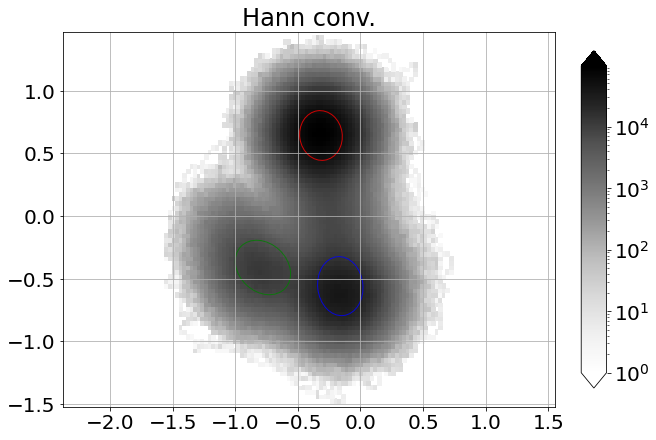

In [118]:
h = plotComplexHist(rhann,ihann)
make_ellipses(gmmHC,h,['red','blue','green'])
plt.title('Hann conv.')
print(gmmHC.weights_)

In [119]:
gmmHC.means_

array([[-0.3153168 ,  0.64367285],
       [-0.16104686, -0.55965349],
       [-0.77886871, -0.41074743]])

In [121]:
dsEst = predictWithBayes(gmmDS,np.vstack((rds,ids)).T,nMemory=3)
sgEst = predictWithBayes(gmmSG,np.vstack((rsg,isg)).T,nMemory=3)
hcEst = predictWithBayes(gmmHC,np.vstack((rhann,ihann)).T,nMemory=3)

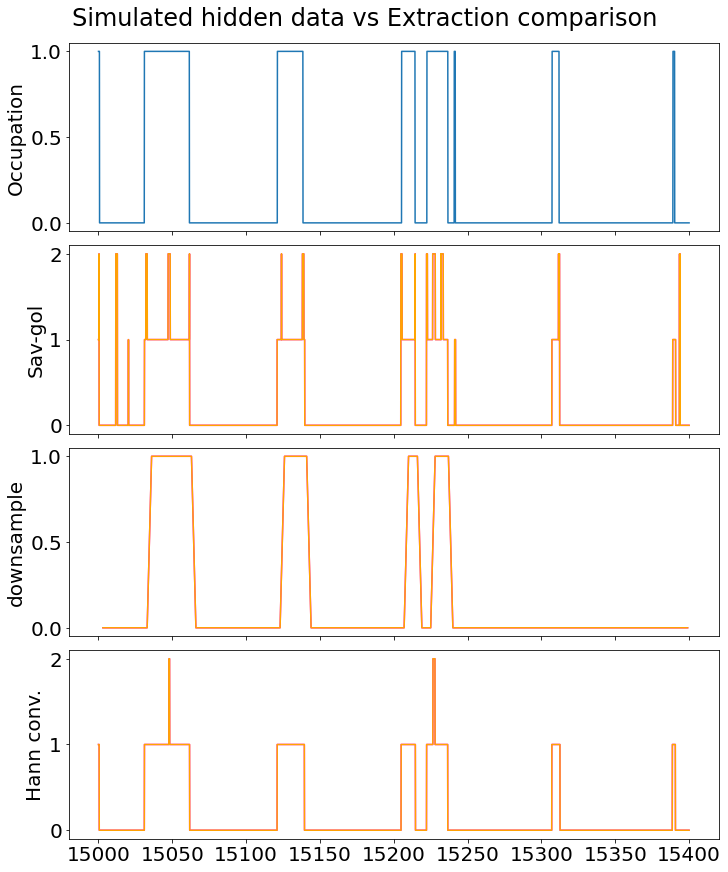

In [122]:
# time2 = np.arange(len(rhann))/SR2 # time in microseconds
mask = np.logical_and(time > 15000,time < 15400)
mask2 = np.logical_and(time2 > 15000, time2 < 15400)
fig,ax = plt.subplots(4,1,sharex=True,figsize=[10,12],constrained_layout=True)
ax[0].plot(time[mask],np.asarray(trapper.nTrapped)[mask])
ax[0].set_ylabel('Occupation')
# ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
# ax[0].legend();
ax[1].plot(time[mask],sgEst[mask],color='magenta',label='real')
ax[1].plot(time[mask],sgEst[mask],color='orange',label='imag')
# ax[1].axvline(time[trapper.burstIndices[0]],color='red')
# ax[1].set_xlabel('time [$\mu$s]')
ax[1].set_ylabel('Sav-gol')
# ax[1].legend();
ax[2].plot(time2[mask2],dsEst[mask2],color='magenta')
ax[2].plot(time2[mask2],dsEst[mask2],color='orange')
ax[2].set_ylabel('downsample')
ax[3].plot(time[mask],hcEst[mask],color='magenta')
ax[3].plot(time[mask],hcEst[mask],color='orange')
ax[3].set_ylabel('Hann conv.')
fig.suptitle('Simulated hidden data vs Extraction comparison');
plt.show();
plt.close();

## What percent of time are each of these wrong?

In [124]:
print('Sav-Gol is wrong {:.4} percent of the time'.format(100*np.mean(sgEst != trapper.nTrapped)))
print('Hann conv. is wrong {:.4} percent of the time'.format(100* np.mean(hcEst != trapper.nTrapped)))

Sav-Gol is wrong 8.524 percent of the time
Hann conv. is wrong 6.89 percent of the time


In [128]:
trueDS = np.round(np.mean(np.asarray(trapper.nTrapped)[:len(res.signal)//(nAvg)*nAvg].reshape((len(res.signal)//(nAvg),nAvg)),axis=1))

TypeError: _around_dispatcher() got an unexpected keyword argument 'dtype'

In [129]:
trueDS = np.array(trueDS,dtype=np.uint16)

In [130]:
print('downsample is wrong {:.4} percent of the time'.format(100*np.mean(dsEst != trueDS)))

downsample is wrong 22.51 percent of the time


#### This seems excessive. maybe the best way to compare these is not to downsample the true occupation, but to expand the downsampled data to match the sample rate of original

In [132]:
dsEst2 = np.repeat(dsEst,nAvg)
print('downsample is wrong {:.4} percent of the time'.format(100*np.mean(dsEst2 != trapper.nTrapped[:dsEst2.size])))

downsample is wrong 23.0 percent of the time


### apparently downsample is excessively bad either way

# Sweep downsample rates to determine if we can get away with saving slower sample rate

In [145]:
samplerates = np.array([30,15,10,6,5,3,2,1])
avgs = np.array(30/samplerates,dtype=int)
print(avgs)

[ 1  2  3  5  6 10 15 30]


weights of each mode for SG at 3e+01 SR are [0.60033516 0.30690826 0.09275658]
weights of each mode for HC at 3e+01 SR are [0.59388137 0.30628755 0.09983107]


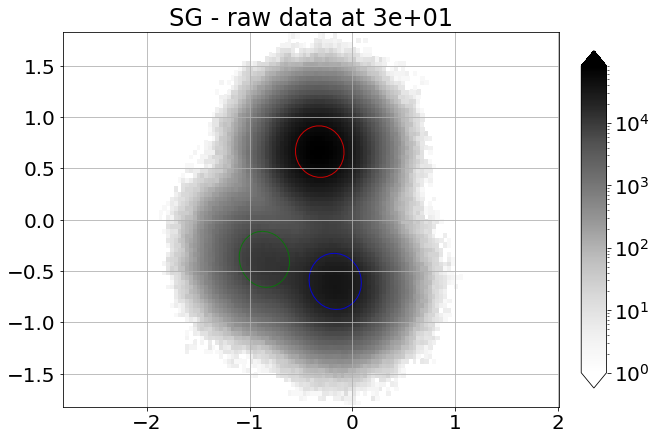

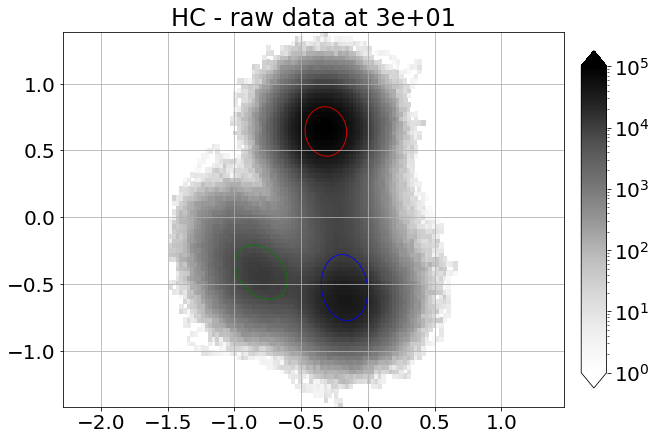

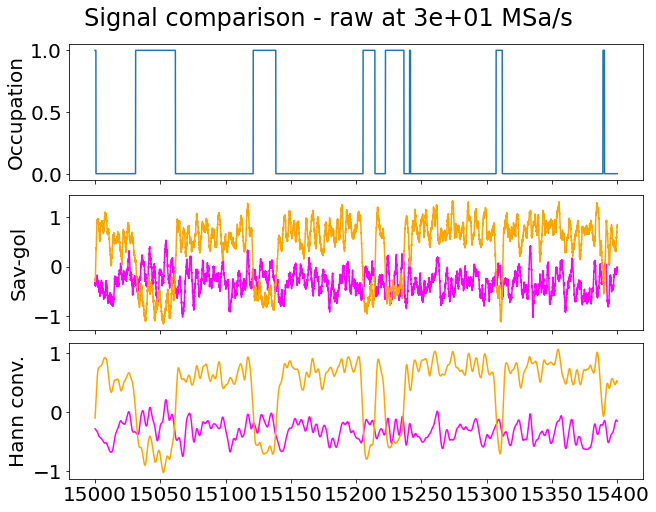

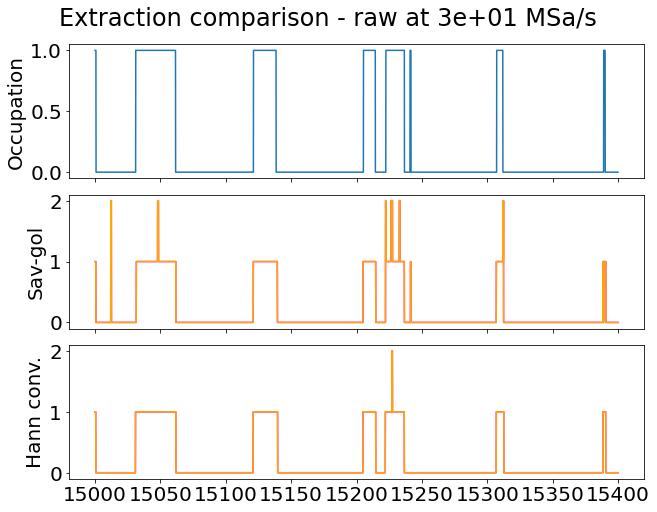

Sav-Gol is wrong 7.769 percent of the time with SR 3e+01
Hann conv. is wrong 7.111 percent of the time with SR 3e+01
weights of each mode for SG at 2e+01 SR are [0.6016633  0.27512154 0.12321516]
weights of each mode for HC at 2e+01 SR are [0.59519    0.30284265 0.10196735]


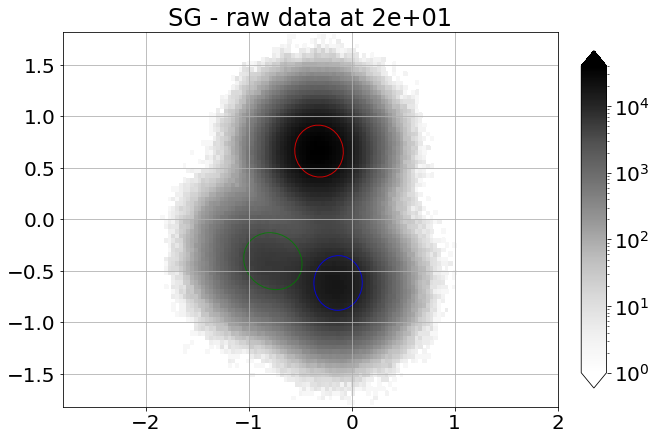

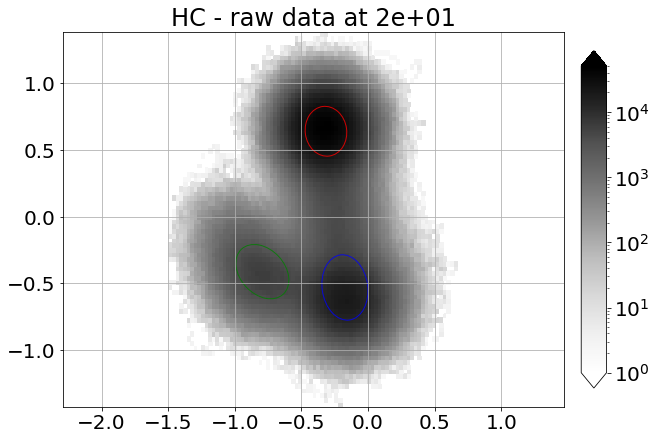

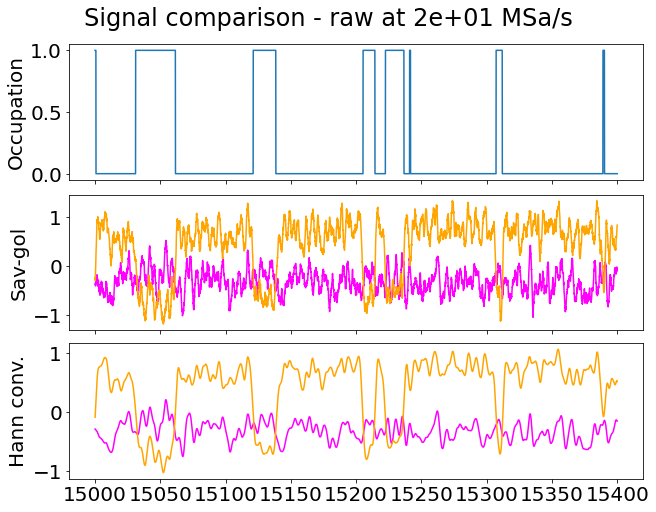

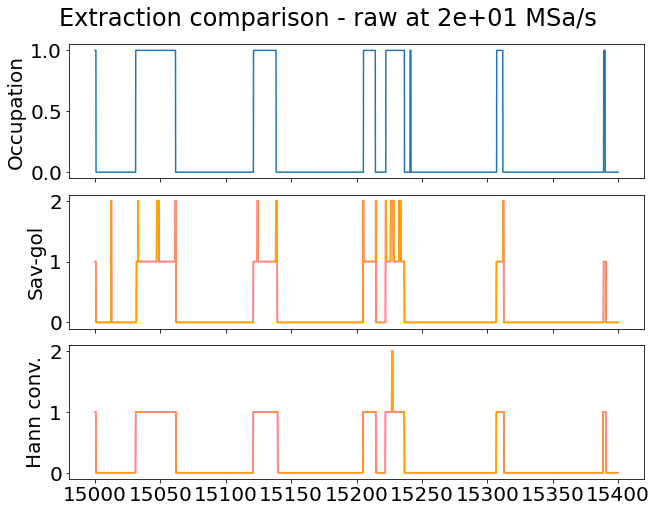

Sav-Gol is wrong 8.101 percent of the time with SR 2e+01
Hann conv. is wrong 7.214 percent of the time with SR 2e+01
weights of each mode for SG at 1e+01 SR are [0.59955127 0.29391276 0.10653597]
weights of each mode for HC at 1e+01 SR are [0.59483109 0.30722129 0.09794762]


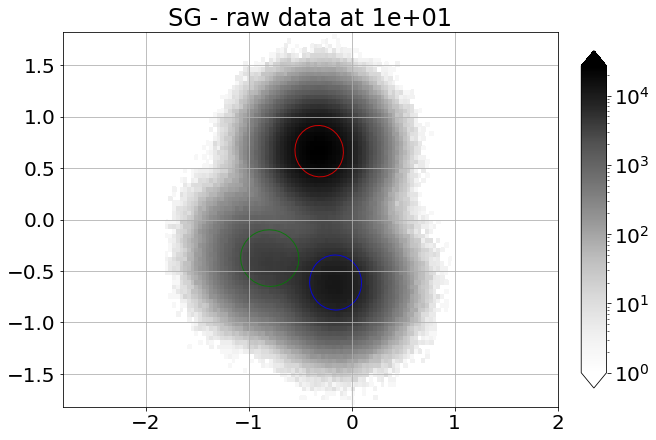

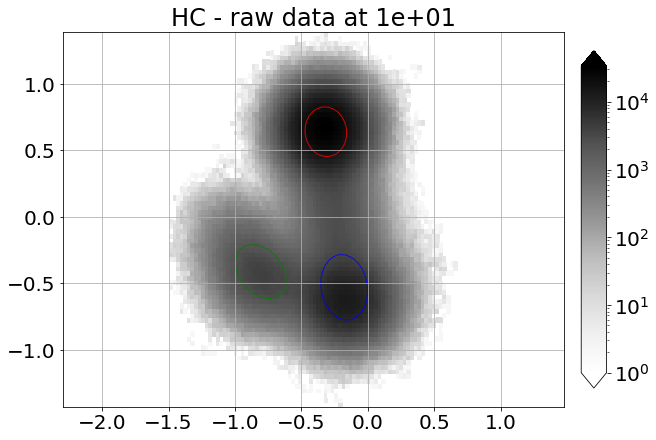

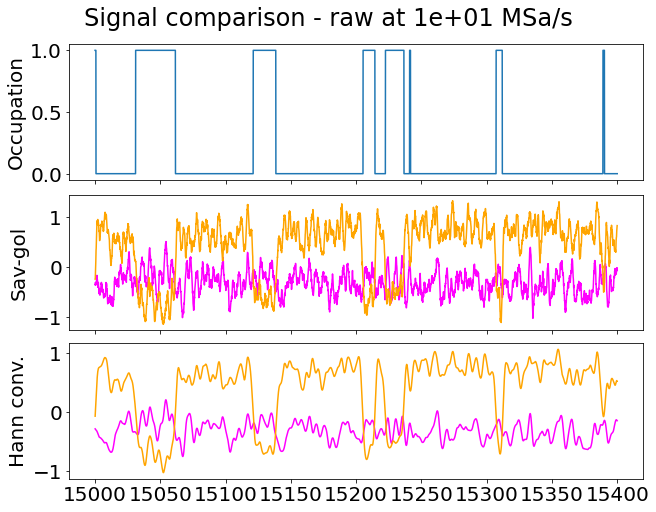

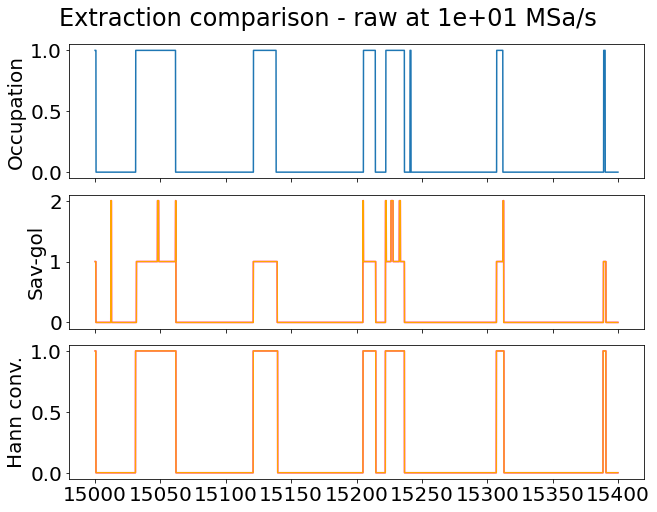

Sav-Gol is wrong 7.981 percent of the time with SR 1e+01
Hann conv. is wrong 7.407 percent of the time with SR 1e+01
weights of each mode for SG at 6e+00 SR are [0.6016114 0.2907767 0.1076119]
weights of each mode for HC at 6e+00 SR are [0.59617786 0.29839444 0.10542771]


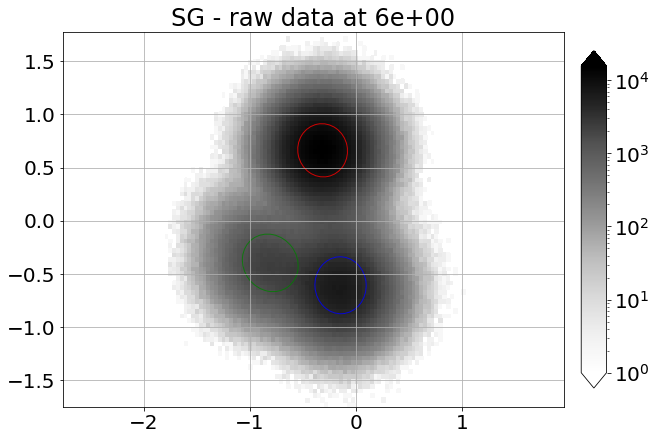

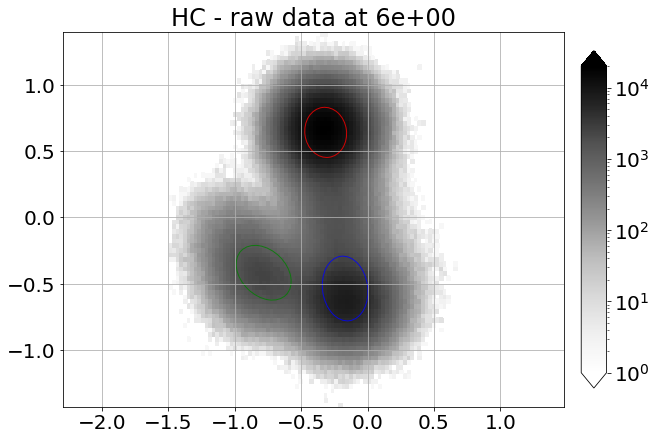

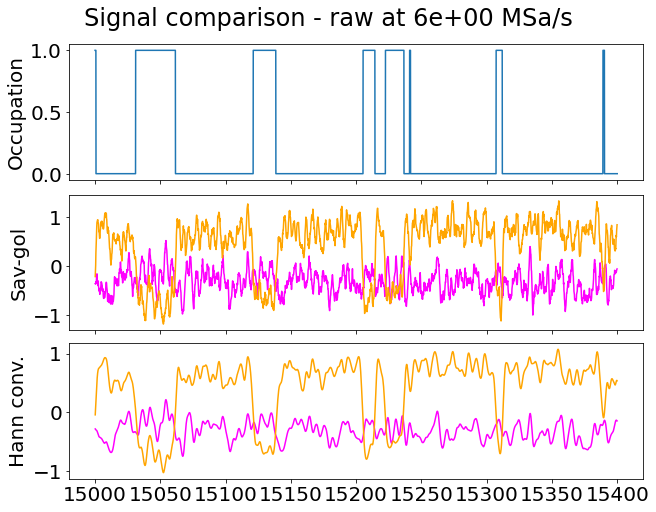

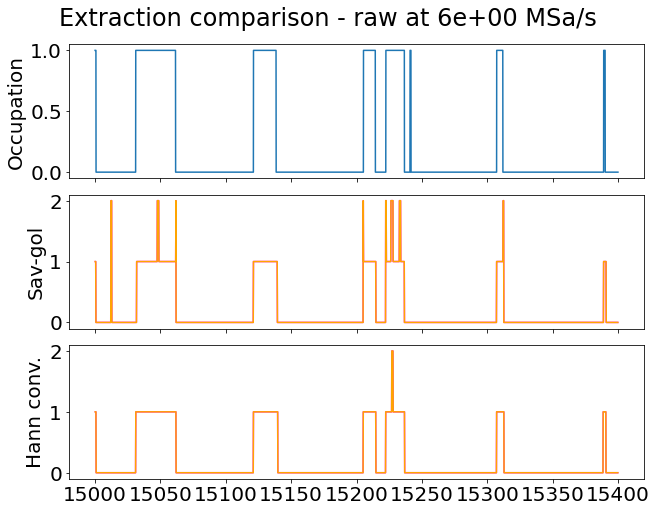

Sav-Gol is wrong 8.2 percent of the time with SR 6e+00
Hann conv. is wrong 7.866 percent of the time with SR 6e+00
weights of each mode for SG at 5e+00 SR are [0.60041752 0.26706184 0.13252064]
weights of each mode for HC at 5e+00 SR are [0.59571702 0.30226188 0.1020211 ]


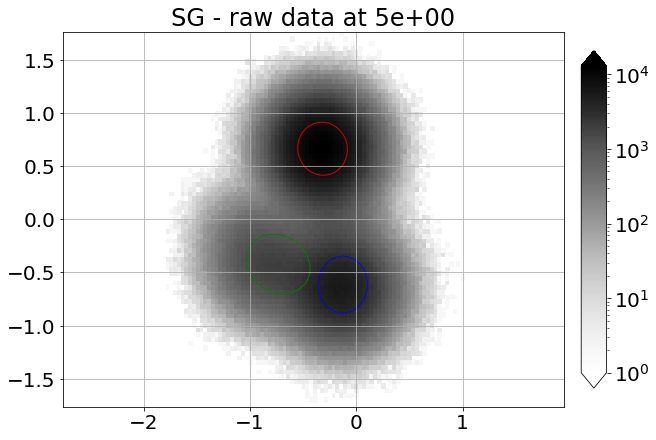

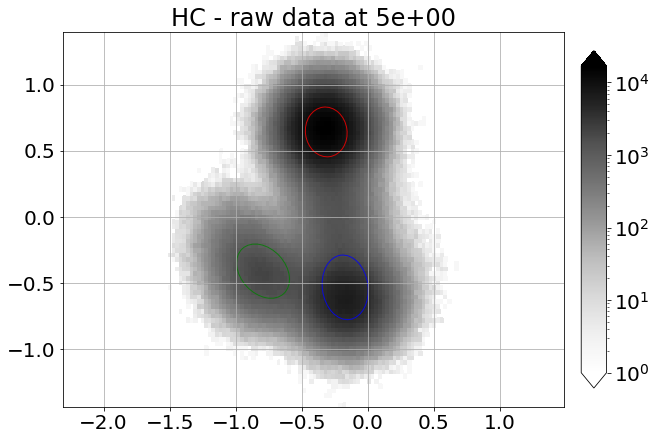

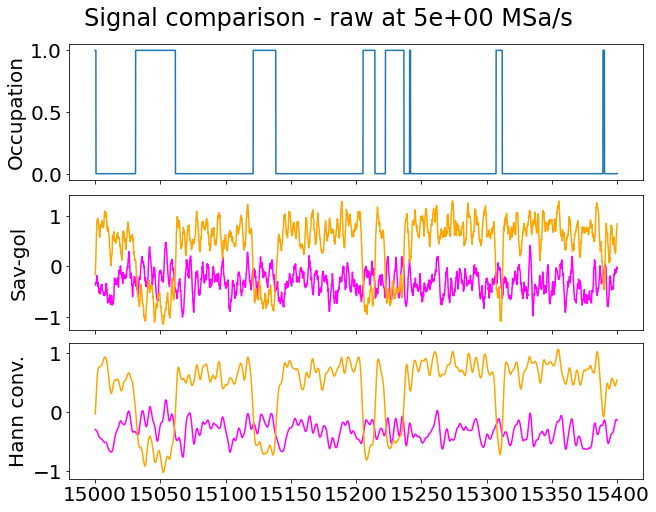

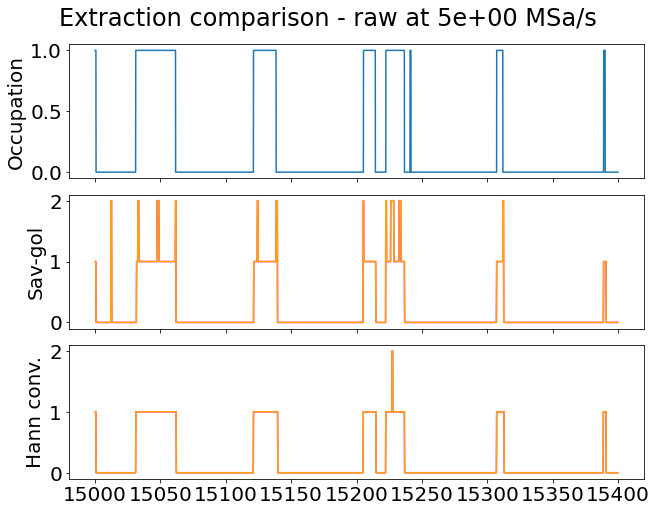

Sav-Gol is wrong 8.81 percent of the time with SR 5e+00
Hann conv. is wrong 8.127 percent of the time with SR 5e+00
weights of each mode for SG at 3e+00 SR are [0.60361315 0.27976776 0.1166191 ]
weights of each mode for HC at 3e+00 SR are [0.59450581 0.29854899 0.1069452 ]


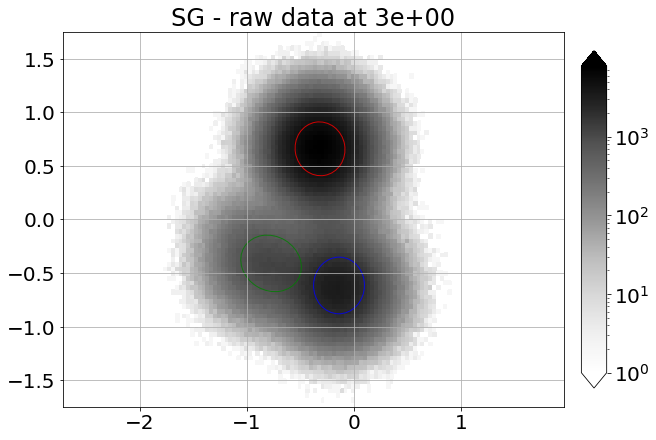

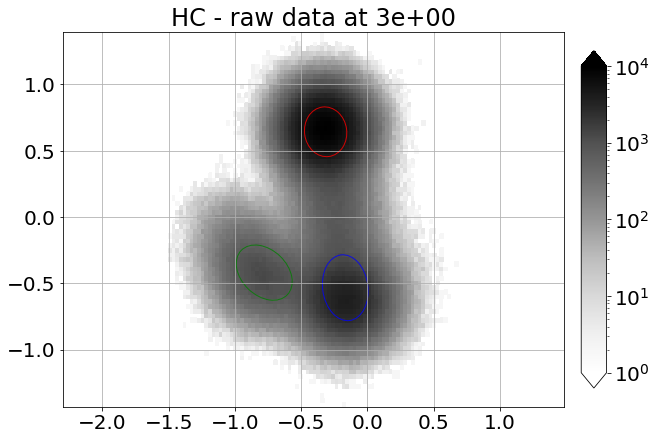

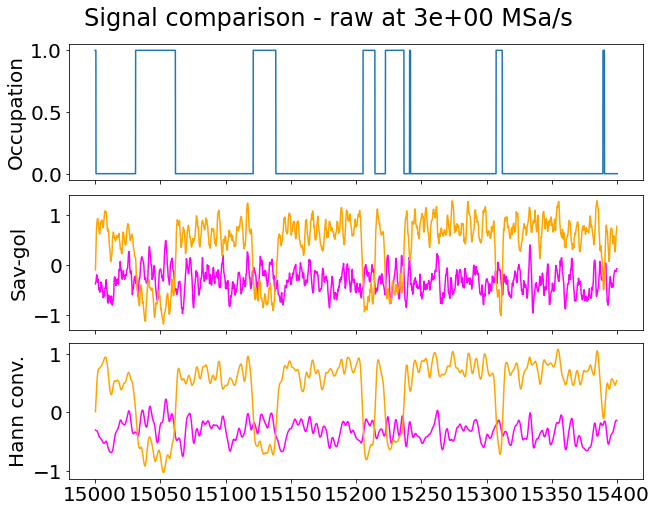

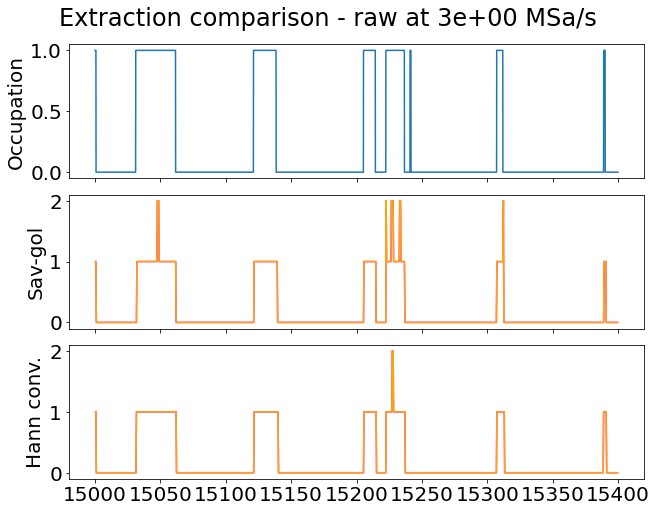

Sav-Gol is wrong 9.221 percent of the time with SR 3e+00
Hann conv. is wrong 9.494 percent of the time with SR 3e+00
weights of each mode for SG at 2e+00 SR are [0.60158302 0.2900048  0.10841219]
weights of each mode for HC at 2e+00 SR are [0.5956504  0.30457829 0.09977131]


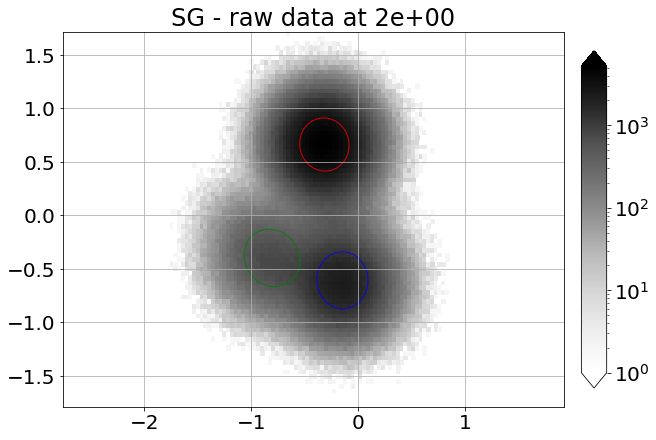

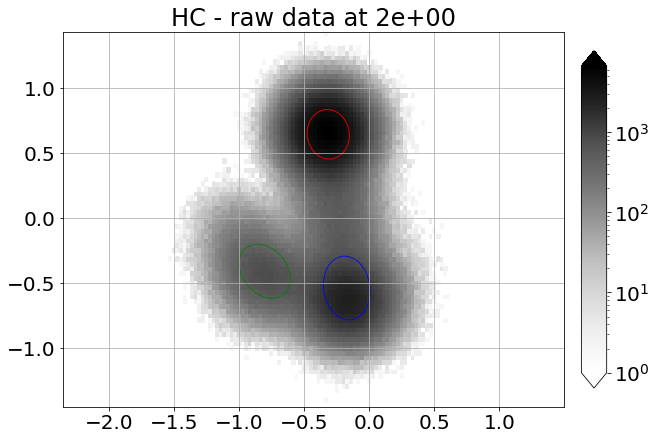

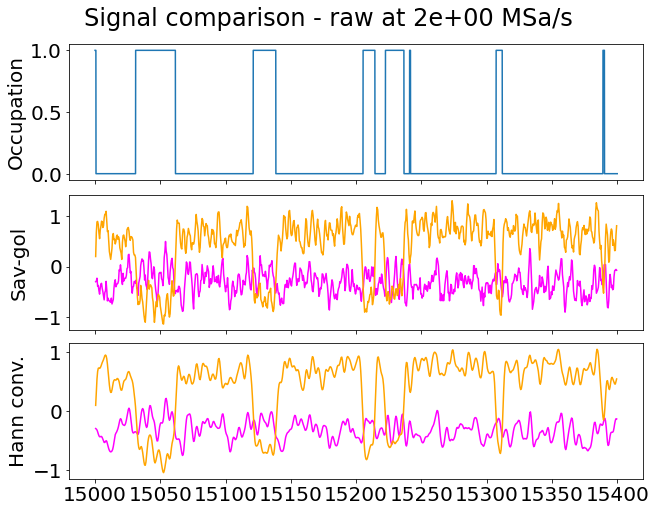

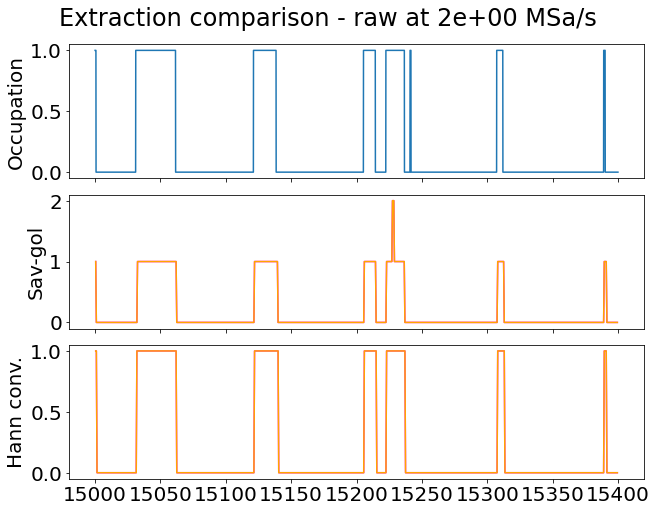

Sav-Gol is wrong 10.3 percent of the time with SR 2e+00
Hann conv. is wrong 11.24 percent of the time with SR 2e+00
weights of each mode for SG at 1e+00 SR are [0.60166917 0.29014371 0.10818711]
weights of each mode for HC at 1e+00 SR are [0.59863957 0.30522938 0.09613105]


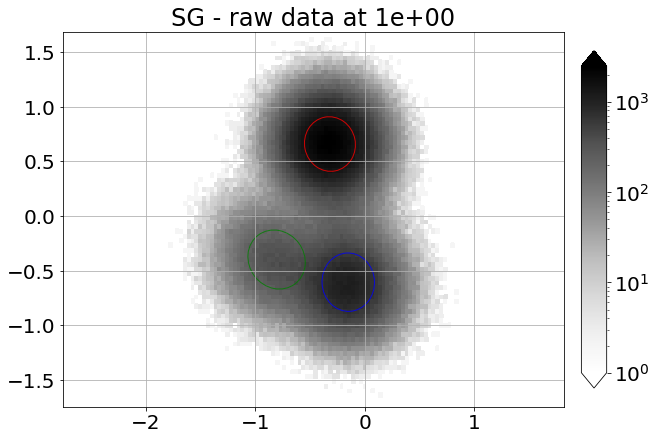

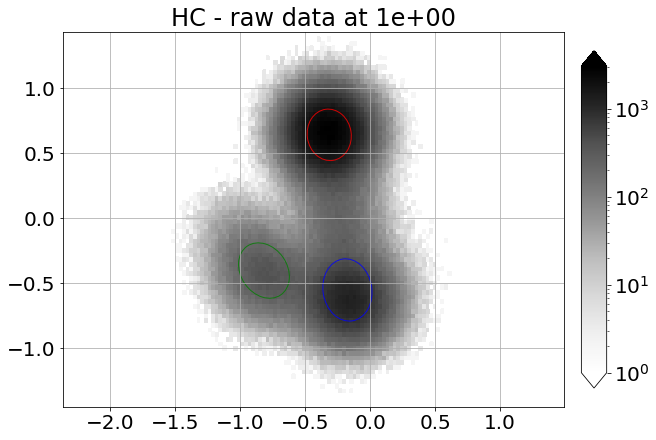

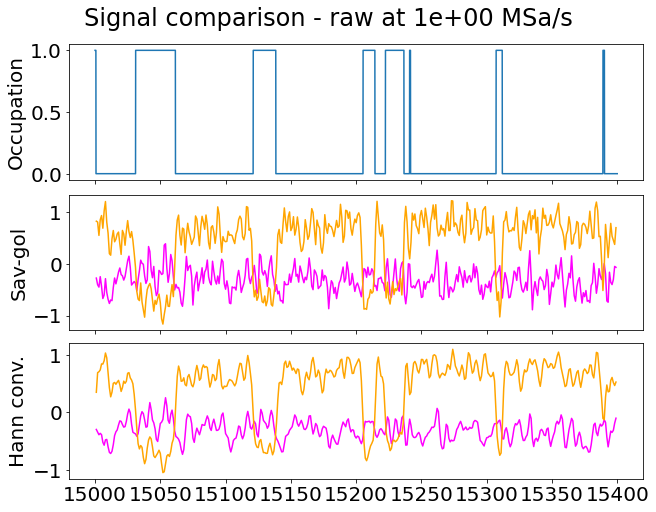

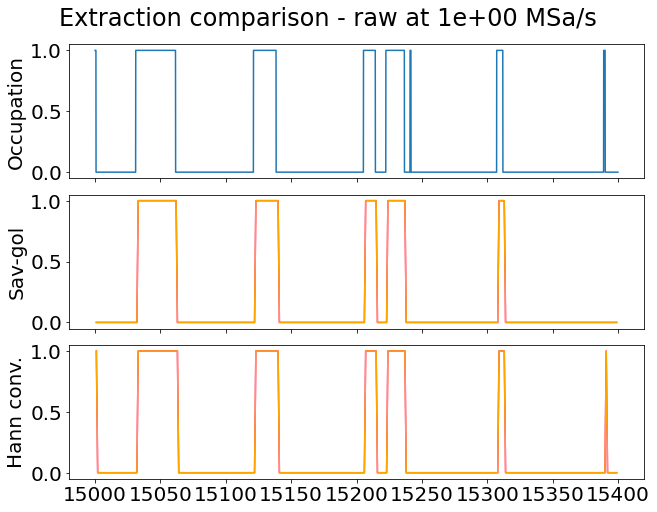

Sav-Gol is wrong 13.79 percent of the time with SR 1e+00
Hann conv. is wrong 16.22 percent of the time with SR 1e+00


In [146]:
hcERR = []
sgERR = []
sgMEAN = []
hcMEAN = []
timeO = np.arange(30000000)/30 # time in microseconds
maskO = np.logical_and(timeO > 15000,timeO < 15400)
for avg in avgs:
    # downsample the data
    DATA = np.vstack((res.signal.real,res.signal.imag))
    nSamplesO = DATA.shape[1]
    DATA = np.mean(DATA[:,:(nSamplesO//avg)*avg].reshape((2,nSamplesO//avg,avg)),axis=-1)
    sampleRate = 30/avg
    nSamples = DATA.shape[1]
    
    # Hann convolution with 6 microsecond window
    hcDATA = HannConvolution(DATA,6,sampleRate)
    
    # Sav-Gol (5th order polynomial) with 6 microsecond window
    window = int(max(6*sampleRate,1))
    window += 0 if window%2 else 1
    sgDATA = savgol_filter(DATA,window,5,axis=-1)
    
    # fit gaussians
    means_guess = [[-0.31548964,  0.64468878],
                   [-0.17672003, -0.55366221],
                   [-0.82593644, -0.39976375]] 
    gmmSG = GaussianMixture(n_components=3,means_init=means_guess)
    gmmHC = GaussianMixture(n_components=3,means_init=means_guess)
    gmmSG.fit(sgDATA.T)
    gmmHC.fit(hcDATA.T)
    
    # plot complex histogram SG
    h = plotComplexHist(sgDATA[0],sgDATA[1])
    make_ellipses(gmmSG,h,['red','blue','green'])
    plt.title('SG - raw data at {:.1}'.format(sampleRate))
    print('weights of each mode for SG at {:.1} SR are {}'.format(sampleRate,gmmSG.weights_))
    
    # plot complex histogram HC
    h = plotComplexHist(hcDATA[0],hcDATA[1])
    make_ellipses(gmmHC,h,['red','blue','green'])
    plt.title('HC - raw data at {:.1}'.format(sampleRate))
    print('weights of each mode for HC at {:.1} SR are {}'.format(sampleRate,gmmHC.weights_))
    
    # compare time series
    time = np.arange(nSamples)/sampleRate # time in microseconds
    mask = np.logical_and(time > 15000,time < 15400)
    fig,ax = plt.subplots(3,1,sharex=True,figsize=[9,7],constrained_layout=True)
    ax[0].plot(timeO[maskO],np.asarray(trapper.nTrapped)[maskO])
    ax[0].set_ylabel('Occupation')
    # ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
    # ax[0].legend();
    ax[1].plot(time[mask],sgDATA[0][mask],color='magenta',label='real')
    ax[1].plot(time[mask],sgDATA[1][mask],color='orange',label='imag')
    # ax[1].axvline(time[trapper.burstIndices[0]],color='red')
    # ax[1].set_xlabel('time [$\mu$s]')
    ax[1].set_ylabel('Sav-gol')
    # ax[1].legend();
    ax[2].plot(time[mask],hcDATA[0][mask],color='magenta')
    ax[2].plot(time[mask],hcDATA[1][mask],color='orange')
    ax[2].set_ylabel('Hann conv.')
    fig.suptitle('Signal comparison - raw at {:.1} MSa/s'.format(sampleRate));
    plt.show();
    plt.close();
    
    # extract occupations using 3 memory window bayes update
    sgEst = predictWithBayes(gmmSG,sgDATA.T,nMemory=3)
    hcEst = predictWithBayes(gmmHC,hcDATA.T,nMemory=3)
    
    # plot extracted occupations time series
    fig,ax = plt.subplots(3,1,sharex=True,figsize=[9,7],constrained_layout=True)
    ax[0].plot(timeO[maskO],np.asarray(trapper.nTrapped)[maskO])
    ax[0].set_ylabel('Occupation')
    # ax[0].axvline(time[trapper.burstIndices[0]],color='red',label='Burst occurs')
    # ax[0].legend();
    ax[1].plot(time[mask],sgEst[mask],color='magenta',label='real')
    ax[1].plot(time[mask],sgEst[mask],color='orange',label='imag')
    # ax[1].axvline(time[trapper.burstIndices[0]],color='red')
    # ax[1].set_xlabel('time [$\mu$s]')
    ax[1].set_ylabel('Sav-gol')
    # ax[1].legend();
    ax[2].plot(time[mask],hcEst[mask],color='magenta')
    ax[2].plot(time[mask],hcEst[mask],color='orange')
    ax[2].set_ylabel('Hann conv.')
    fig.suptitle('Extraction comparison - raw at {:.1} MSa/s'.format(sampleRate));
    plt.show();
    plt.close();
    
    # keep the relevant information
    sgmean = np.mean(sgEst)
    sgMEAN.append(sgmean)
    sger = 100*np.mean(np.repeat(sgEst,avg) != trapper.nTrapped)
    sgERR.append(sger)
    
    hcmean = np.mean(hcEst)
    hcMEAN.append(hcmean)
    hcer = 100*np.mean(np.repeat(hcEst,avg) != trapper.nTrapped)
    hcERR.append(hcer)
    
    print('Sav-Gol is wrong {:.4} percent of the time with SR {:.1}'.format(sger,sampleRate))
    print('Hann conv. is wrong {:.4} percent of the time with SR {:.1}'.format(hcer,sampleRate))

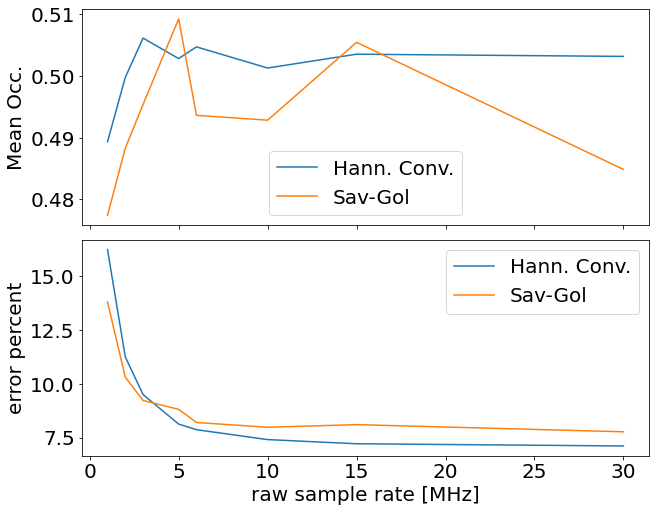

In [148]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=[9,7],constrained_layout=True)
ax[0].plot(samplerates,hcMEAN,label='Hann. Conv.')
ax[0].plot(samplerates,sgMEAN,label='Sav-Gol')
ax[0].set_ylabel('Mean Occ.');
ax[0].legend();
ax[1].plot(samplerates,hcERR,label='Hann. Conv.')
ax[1].plot(samplerates,sgERR,label='Sav-Gol')
ax[1].set_ylabel('error percent')
ax[1].set_xlabel('raw sample rate [MHz]');
ax[1].legend();

## Save raw data and such for later processing

In [149]:
import pickle
with open(savepath+'trueOccupation.bin','wb') as f:
    # to recover, use np.fromfile(f,dtype=int)
    np.asarray(trapper.nTrapped,dtype=int).tofile(f)
with open(savepath+'signal.bin','wb') as f:
    # to recover, use np.fromfile(f,dtype=np.float64), then reshape to (2,3e7)
    np.hstack((res.signal.real,res.signal.imag)).astype(np.float64).tofile(f)
with open(savepath+'trapper.pkl','wb') as f:
    pickle.dump(trapper,f)
with open(savepath+'res.pkl','wb') as f:
    pickle.dump(res,f)

In [150]:
with open(savepath+'trapper.pkl','rb') as f:
    trapper2 = pickle.load(f)
with open(savepath+'res.pkl','rb') as f:
    res2 = pickle.load(f)

In [154]:
res2.signal.all() == res.signal.all()

True

# Is this level of SNR sufficient for machine learning alg to detect occupation?

In [ ]:
avgTime25

### We're already averaging for 18.6 microseconds and assuming quantum limited noise

In [ ]:
print('avg # trapped = {:.4}'.format(np.mean(trapper.nTrapped)))
print('max # = {}'.format(np.max(trapper.nTrapped)))

# use scikit package for expectation-maximization algorithm to fit gaussian mixture

In [ ]:
from sklearn.mixture import GaussianMixture

### initial guess at mode locations, based on looking at complex hist

In [ ]:
means_guess = np.array([[-0.5,0.4,-0.6,-1],[0.75,-0.25,-0.5,0]]).T

## run the ML algorithm

In [ ]:
estimator = GaussianMixture(n_components = len(means_guess),means_init=means_guess)
estimator.fit(np.array([rhann,ihann]).T)

### Did it work?

In [ ]:
estimator.converged_

In [ ]:
estimator.means_

## Make the pretty plot

In [ ]:
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

colors = ['red','orange','yellow','green']
def make_ellipses(gmm,ax):
    for n, color in enumerate(colors):
        # get the covariance matrix for the mode associated with n trapped QPs
        covariances = gmm.covariances_[n][:2,:2]
        # v are the eigenvalues of covariance matrix, aka the variances along major and minor axis of ellipse. w are the eigenvectors. Order is smallest to v to largest v
        v, w = np.linalg.eigh(covariances)
        # normalize the eigenvector associated with the smallest variance, i.e., the variance along the minor axis.
        u = w[0] / np.linalg.norm(w[0])
        # get the angle from +x axis to minor axis of ellipse
        angle = 180*np.arctan2(u[1],u[0])/np.pi
        # v is now the diameter of the ellipse in minor, major order. It is equal to 2 std deviations.
        v = 2. *np.sqrt(v)
        # make the ellipse for mode n. Centered at mean with major and minor radius of 1 std deviation. and rotated to align to the data.
        ell = Ellipse(gmm.means_[n,:2],v[0],v[1],180+angle,color=color)
        # now we just add the ellipses to the plot. Note that these ellipses shade the area in which all data points are within 1 std deviation of the mean.
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.9)
        ax.add_artist(ell)
        ax.set_aspect('equal','datalim')

h = plt.subplot()
make_ellipses(estimator,h)
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
plt.savefig(savepath+r'NBR07_hist_modes.png',format='png')
plt.show()

# Does the estimator accurately predict the trap state?

In [ ]:
nEst = np.empty(res.dParams['N'],dtype=int)
nEst[:] = estimator.predict(np.transpose((rhann,ihann)))

### How do the avg number of trapped QPs compare?

In [ ]:
print('simulated avg # = {:.4}'.format(np.mean(trapper.nTrapped)))
print('estimator avg # = {:.4}'.format(np.mean(nEst)))

### That's a good agreement. How does it look when we plot two segments together?

In [ ]:
h = plt.subplot()
h.plot(time[100000:500000]*1e6,trapper.nTrapped[100000:500000],'r',alpha=0.9,label='Simulation',lw=0.8)
h.plot(time[100000:500000]*1e6,nEst[100000:500000],'b',alpha=0.9,label='Estimated',lw=0.8)
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('Number of trapped QPs',fontsize = 14)
plt.yticks([0,1,2,3,4])
h.tick_params(labelsize=12)
h.legend(fontsize=14)
plt.savefig(savepath+r'NBR07_estimationComparison.png',format='png')
plt.show()

### Looks like the estimator is switching far too often. perhaps a different averaging method will work better (instead of convolution with Hann window)

## Let's quantitatively look at the error

In [ ]:
errTrap = np.diff((nEst,trapper.nTrapped),axis=0)[0]

#### errTrap is the difference, errTrap[i] = nTrapped[i] - nEst[i]. It should be positive when we underestimate and negative when we overestimate. The mean should approach 0 for large dataset unless we are somehow more prone to over or under estimating.

In [ ]:
np.mean(errTrap)

##### Ok, now let's quantify the error. The root mean square of the difference should tell us what percent of the time we're wrong about the state.

In [ ]:
np.sqrt(np.mean(errTrap**2))*100 

#### Being wrong 40% of the time isn't exactly something to brag about..

### Actually, the above isn't really how often we're wrong, but overestimates this since errTrap is the difference and can be greater than zero. what we need is an array that is 0 when the estimator is right and 1 when it is wrong. mean of this is the actual percent of time we're wrong.

In [ ]:
estFalse = np.array(np.abs(errTrap) > 0,dtype=int)

In [ ]:
np.mean(estFalse)

# Repeat for exponential window

In [ ]:
nAvg = int(max(5e-6*res.dParams['sampleRate'],1))
window = windows.exponential(nAvg,tau=-(nAvg-1)/np.log(0.00001))
rhann = convolve(res.signal.real,window,mode='same')/sum(window)
ihann = convolve(res.signal.imag,window,mode='same')/sum(window)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
time = np.arange(res.dParams['N'])/res.dParams['sampleRate']

h = plt.subplot()
h.plot(time[150000:250000]*1e6,rhann[150000:250000],'r',alpha=0.9,label='I(t)')
h.plot(time[150000:250000]*1e6,ihann[150000:250000],'b',alpha=0.9,label='Q(t)')
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('V / |V|',fontsize = 14)
h.tick_params(labelsize=12)
h.legend(fontsize=12)
plt.savefig(savepath+r'NBR07_noisySignal_SNR25_exp.png',format='png')
plt.show()

In [ ]:
plt.plot(window)

In [ ]:
nAvg

In [ ]:
h = plt.subplot()
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
h.set_aspect('equal')
h.grid()
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
plt.savefig(savepath+r'NBR07_hist_exp.png',format='png')
plt.show()

In [ ]:
h,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time*1e3,np.arctan((ihann/rhann)))
ax[0].set_ylabel('phase [rad]')
ax[1].plot(time*1e3,np.sqrt(rhann**2 + ihann**2))
ax[1].set_ylabel('Magnitude')
ax[1].set_xlabel('time [ms]')
plt.savefig(savepath+r'NBR07_mag_phase_exp.png',format='png')
plt.show()

In [ ]:
estimator = GaussianMixture(n_components = len(means_guess),means_init=means_guess)
estimator.fit(np.array([rhann,ihann]).T)

In [ ]:
estimator = GaussianMixture(n_components = len(means_guess),means_init=means_guess)
estimator.fit(np.array([rhann,ihann]).T)

### Did it work?

estimator.converged_

estimator.means_

In [ ]:
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

colors = ['red','orange','yellow','green']
def make_ellipses(gmm,ax):
    for n, color in enumerate(colors):
        # get the covariance matrix for the mode associated with n trapped QPs
        covariances = gmm.covariances_[n][:2,:2]
        # v are the eigenvalues of covariance matrix, aka the variances along major and minor axis of ellipse. w are the eigenvectors. Order is smallest to v to largest v
        v, w = np.linalg.eigh(covariances)
        # normalize the eigenvector associated with the smallest variance, i.e., the variance along the minor axis.
        u = w[0] / np.linalg.norm(w[0])
        # get the angle from +x axis to minor axis of ellipse
        angle = 180*np.arctan2(u[1],u[0])/np.pi
        # v is now the diameter of the ellipse in minor, major order. It is equal to 2 std deviations.
        v = 2. *np.sqrt(v)
        # make the ellipse for mode n. Centered at mean with major and minor radius of 1 std deviation. and rotated to align to the data.
        ell = Ellipse(gmm.means_[n,:2],v[0],v[1],180+angle,color=color)
        # now we just add the ellipses to the plot. Note that these ellipses shade the area in which all data points are within 1 std deviation of the mean.
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.9)
        ax.add_artist(ell)
        ax.set_aspect('equal','datalim')

h = plt.subplot()
make_ellipses(estimator,h)
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
plt.savefig(savepath+r'NBR07_hist_modes_exp.png',format='png')
plt.show()

In [ ]:
nEst = np.empty(res.dParams['N'],dtype=int)
nEst[:] = estimator.predict(np.transpose((rhann,ihann)))

### How do the avg number of trapped QPs compare?

print('simulated avg # = {:.4}'.format(np.mean(trapper.nTrapped)))
print('estimator avg # = {:.4}'.format(np.mean(nEst)))

### That's a good agreement. How does it look when we plot two segments together?

h = plt.subplot()
h.plot(time[100000:500000]*1e6,trapper.nTrapped[100000:500000],'r',alpha=0.9,label='Simulation',lw=0.8)
h.plot(time[100000:500000]*1e6,nEst[100000:500000],'b',alpha=0.9,label='Estimated',lw=0.8)
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('Number of trapped QPs',fontsize = 14)
plt.yticks([0,1,2,3,4])
h.tick_params(labelsize=12)
h.legend(fontsize=14)
plt.savefig(savepath+r'NBR07_estimationComparison_exp.png',format='png')
plt.show()

In [ ]:
def f_n_phi(phi,n, L = 1.82897e-9,C = 0.739929e-12,Lj = 20.8475e-12):
    de = np.pi*phi
    Ljphi = Lj/(1-np.sin(de/2)*np.arctanh(np.sin(de/2)))
    q = Ljphi/(L+Ljphi)
    Delta=2.72370016e-23
    rphi0 = (2.06783383*1e-15)/(2*np.pi)
    f0 = 1/(2*np.pi*np.sqrt((L+Ljphi)*C))
    alpha = Delta/(2*(rphi0**2))
    L1 = alpha*(np.cos(de)/np.sqrt(1-np.sin(de/2)**2) + (np.sin(de)**2)/(4*(np.sqrt(1-np.sin(de/2)**2)**3)))
    return f0 -  (q*f0*Ljphi*n*L1/2)
#     return L1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x = np.arange(0,0.45,0.01)

In [ ]:
plt.plot(x,f_n_phi(x,0))
plt.plot(x,f_n_phi(x,1))
plt.plot(x,f_n_phi(x,2))
plt.plot(x,f_n_phi(x,3))

In [ ]:
plt.plot(x,np.squeeze(np.diff((f_n_phi(x,1),f_n_phi(x,0)),axis=0)))